# Training a basic ANN on MNIST

In [58]:
import equinox as eqx
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

In [5]:
# Hyperparameters


BATCH_SIZE = 64

LEARNING_RATE = 0.005

STEPS = 300

PRINT_EVERY = 30

SEED = 5678

key = jax.random.PRNGKey(SEED)

## Loading dataset

In [6]:
normalise_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=normalise_data,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=normalise_data,
)
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

### Splitting MNIST into 2 balanced, distinct datasets

In [78]:
train_data = jnp.array(train_dataset.data)
train_targets = jnp.array(train_dataset.targets)

balanced_train_data = []
balanced_train_targets = []
counts = 10 * [0]

for i, target in enumerate(train_targets):
    if counts == 10 * [5400]:
        break
    
    if counts[target] < 5400:
        counts[target] += 1
        balanced_train_targets.append(target)
        balanced_train_data.append(train_data[i])

    
balanced_train_targets = jnp.array(balanced_train_targets)
balanced_train_data = jnp.array(balanced_train_data)


print("Original train_dataset counts")
print(jnp.bincount(train_targets))

print("Balanced train_dataset counts")
print(jnp.bincount(balanced_train_targets))


Original train_dataset counts
[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Balanced train_dataset counts
[5400 5400 5400 5400 5400 5400 5400 5400 5400 5400]


In [79]:
test_data = jnp.array(test_dataset.data)
test_targets = jnp.array(test_dataset.targets)

balanced_test_data = []
balanced_test_targets = []
counts = 10 * [0]

for i, target in enumerate(test_targets):
    if counts == 10 * [890]:
        break
    
    if counts[target] < 890:
        counts[target] += 1
        balanced_test_targets.append(target)
        balanced_test_data.append(test_data[i])

    
balanced_test_targets = jnp.array(balanced_test_targets)
balanced_test_data = jnp.array(balanced_test_data)


print("Original test_dataset counts")
print(jnp.bincount(test_targets))

print("Balanced test_dataset counts")
print(jnp.bincount(balanced_test_targets))


Original test_dataset counts
[ 980 1135 1032 1010  982  892  958 1028  974 1009]
Balanced test_dataset counts
[890 890 890 890 890 890 890 890 890 890]


In [82]:
data_test = jnp.array(test_dataset.targets)
print("Test Dataset shape")
print(data_test.shape)
print(jnp.bincount(data_test))

print("original train data shape")
print(train_data.shape)
print("balanced train data shape")
print(balanced_train_data.shape)

print("Original Test Targets shape")
print(test_targets.shape)
print("Balanced Test Targets shape")
print(balanced_test_targets.shape)



Test Dataset shape
(10000,)
[ 980 1135 1032 1010  982  892  958 1028  974 1009]
original train data shape
(60000, 28, 28)
balanced train data shape
(54000, 28, 28)
Original Test Targets shape
(10000,)
Balanced Test Targets shape
(8900,)


(27000, 28, 28)
(27000, 28, 28)
Balance y1_train
[2700 2700 2700 2700 2700 2700 2700 2700 2700 2700]
Balance y2_train
[2700 2700 2700 2700 2700 2700 2700 2700 2700 2700]
This should be a 9


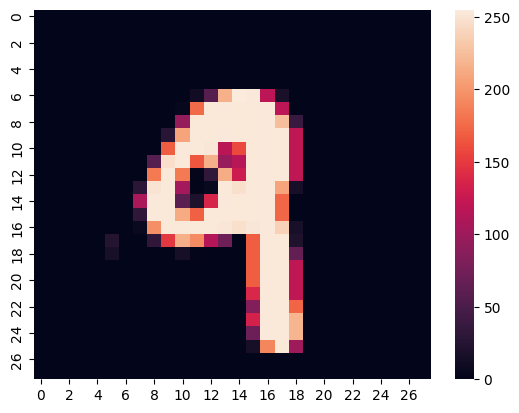

This should be a 6


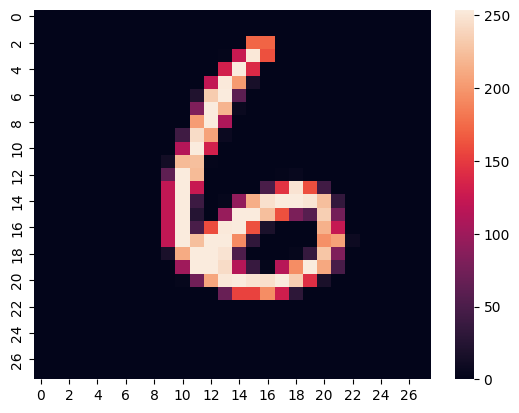

This should be a 6


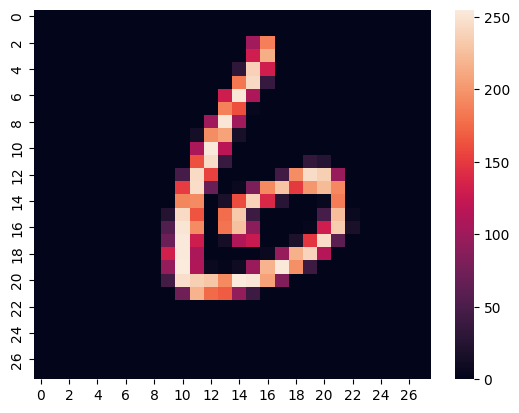

This should be a 9


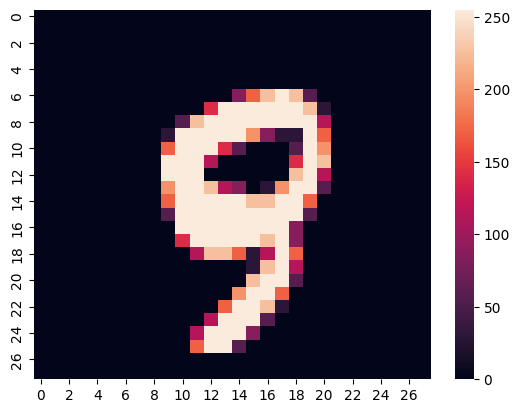

In [83]:
X1_train, X2_train, y1_train, y2_train = sklearn.model_selection.train_test_split(balanced_train_data,balanced_train_targets, train_size = 0.5, stratify=balanced_train_targets)

print(X1_train.shape)
print(X2_train.shape)

# check if datasets balanced

unique, counts = jnp.unique(X1_train, return_counts=True)

print("Balance y1_train")
print(jnp.bincount(y1_train))

print("Balance y2_train")
print(jnp.bincount(y2_train))

# sanity check the labels correspond to the images

print("This should be a", y1_train[69])
sns.heatmap(X1_train[69])
plt.show()
print("This should be a", y1_train[-1])
sns.heatmap(X1_train[-1])
plt.show()
print("This should be a", y2_train[800])
sns.heatmap(X2_train[800])
plt.show()
print("This should be a", y2_train[1111])
sns.heatmap(X2_train[1111])
plt.show()


(4450, 28, 28)
(4450, 28, 28)
Balance y1_test
[445 445 445 445 445 445 445 445 445 445]
Balance y2_test
[445 445 445 445 445 445 445 445 445 445]
This should be a 8


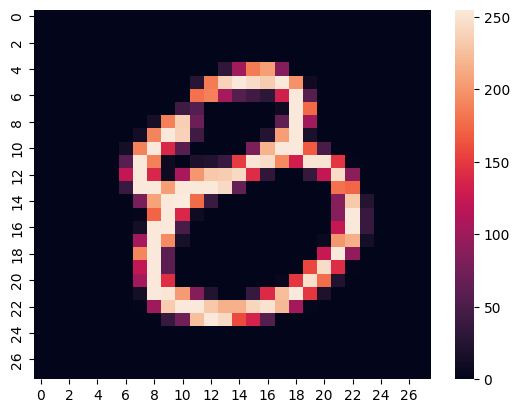

This should be a 4


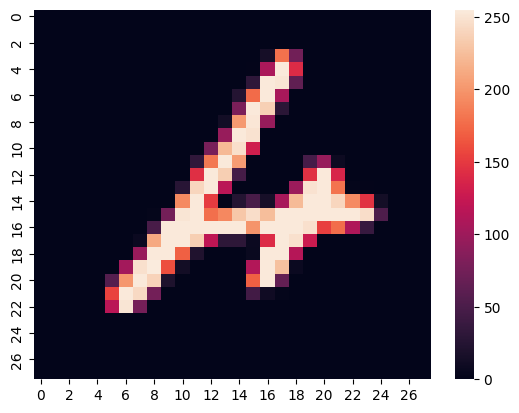

This should be a 0


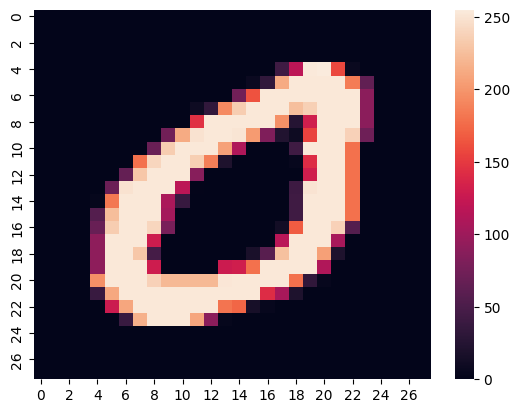

This should be a 7


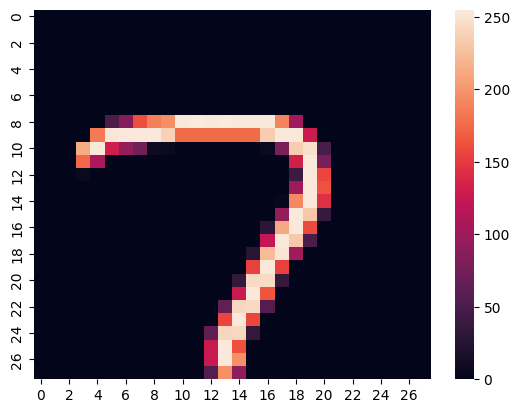

In [85]:
X1_test, X2_test, y1_test, y2_test = sklearn.model_selection.train_test_split(balanced_test_data,balanced_test_targets, test_size = 0.5, stratify=balanced_test_targets)

print(X1_test.shape)
print(X2_test.shape)

# check if datasets balanced

unique, counts = jnp.unique(X1_test, return_counts=True)

print("Balance y1_test")
print(jnp.bincount(y1_test))

print("Balance y2_test")
print(jnp.bincount(y2_test))

# sanity check the labels correspond to the images

print("This should be a", y1_test[69])
sns.heatmap(X1_test[69])
plt.show()
print("This should be a", y1_test[-1])
sns.heatmap(X1_test[-1])
plt.show()
print("This should be a", y2_test[800])
sns.heatmap(X2_test[800])
plt.show()
print("This should be a", y2_test[1111])
sns.heatmap(X2_test[1111])
plt.show()


In [123]:
from torch.utils.data import Dataset
import numpy as np

class CustomDataset(Dataset):

    import numpy as np

    def __init__(self, data, targets):
        data = np.array(data, dtype= np.float32)
        data = np.expand_dims(data, axis= 0)
        self.data = torch.from_numpy(data)

        targets = np.array(targets)
        self.targets = torch.from_numpy(targets) 

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):

        return self.data[:, idx, :, :], self.targets[idx]


    # def _load_data(self):
    #     return  X1_train, y1_train
    
    
# class Agent2_Train(Dataset):
#     def _load_data(self):
#         return  X2_train, y2_train
    
# class Agent2_Test(Dataset):
#     def _load_data(self):
#         return  X2_test, y2_test

print("type of data outside class")
print(type(X1_train))

Agent1_Train_dataset = CustomDataset(
    data= X1_train,
    targets= y1_train
)

Agent1_Test_dataset = CustomDataset(
    data= X1_test,
    targets= y1_test
)

trainloader = torch.utils.data.DataLoader(
    Agent1_Train_dataset, batch_size=BATCH_SIZE, shuffle=True
)

testloader = torch.utils.data.DataLoader(
    Agent1_Test_dataset, batch_size=BATCH_SIZE, shuffle=True
)



type of data outside class
<class 'jaxlib.xla_extension.ArrayImpl'>


(64, 1, 28, 28)
(64,)
[1 6 2 2 9 4 1 8 8 0 2 6 3 6 2 4 1 5 1 5 3 5 8 7 1 3 0 7 3 4 2 1 9 2 5 1 0
 4 0 4 8 7 9 0 5 3 3 0 9 1 8 3 8 8 9 7 8 8 2 7 6 0 6 9]
This should be a 2


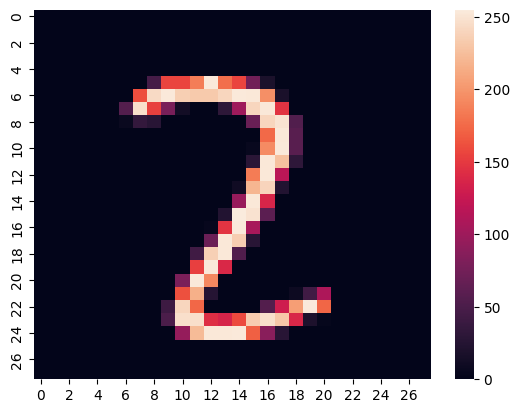

This should be a 5


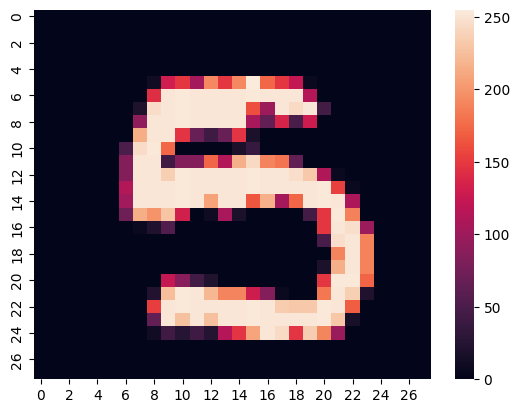

This should be a 9


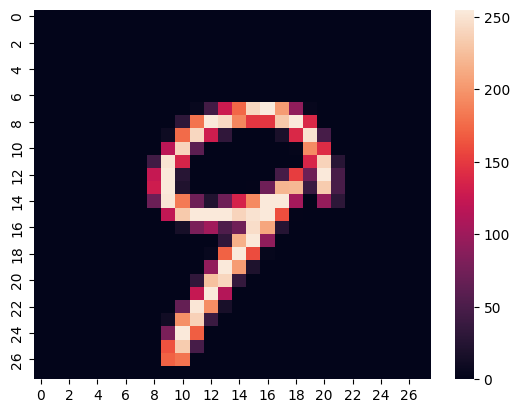

In [124]:
# Checking our data a bit (by now, everyone knows what the MNIST dataset looks like)
dummy_x, dummy_y = next(iter(trainloader))

dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # 64x1x28x28
print(dummy_y.shape)  # 64
print(dummy_y)

# Sanity check
print("This should be a", dummy_y[3])
sns.heatmap(dummy_x[3][0])
plt.show()
print("This should be a", dummy_y[21])
sns.heatmap(dummy_x[21][0])
plt.show()
print("This should be a", dummy_y[-1])
sns.heatmap(dummy_x[-1][0])
plt.show()


## Everything is in order with the split dataset
- now making split trainloaders

In [133]:
# ------------- Agent 1 data loaders

Agent1_Train_dataset = CustomDataset(
    data= X1_train,
    targets= y1_train
)
Agent1_Test_dataset = CustomDataset(
    data= X1_test,
    targets= y1_test
)

trainloader_Agent1 = torch.utils.data.DataLoader(
    Agent1_Train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader_Agent1 = torch.utils.data.DataLoader(
    Agent1_Test_dataset, batch_size=BATCH_SIZE, shuffle=True
)


# ------------- Agent 2 data loaders

Agent2_Train_dataset = CustomDataset(
    data= X2_train,
    targets= y2_train
)
Agent2_Test_dataset = CustomDataset(
    data= X2_test,
    targets= y2_test
)
trainloader_Agent2 = torch.utils.data.DataLoader(
    Agent2_Train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader_Agent2 = torch.utils.data.DataLoader(
    Agent2_Test_dataset, batch_size=BATCH_SIZE, shuffle=True
)


## Making 2 ANNs with the exact same initialization 

In [134]:
class CNN(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        # Standard CNN setup: convolutional layer, followed by flattening,
        # with a small MLP on top.
        self.layers = [
            eqx.nn.Conv2d(1, 3, kernel_size=4, key=key1),
            eqx.nn.MaxPool2d(kernel_size=2),
            jax.nn.relu,
            jnp.ravel,
            eqx.nn.Linear(1728, 512, key=key2),
            jax.nn.sigmoid,
            eqx.nn.Linear(512, 64, key=key3),
            jax.nn.relu,
            eqx.nn.Linear(64, 10, key=key4),
            jax.nn.log_softmax,
        ]

    def __call__(self, x: Float[Array, "1 28 28"]) -> Float[Array, "10"]:
        for layer in self.layers:
            x = layer(x)
        return x

SEED = 5678
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key, 2)

agent1 = CNN(subkey)
agent2 = CNN(subkey)

In [143]:
print("Do agent 1 and 2 have the same weights in the first layer?")
print(agent1.layers[0].weight.all() == agent2.layers[0].weight.all())

print(agent1.layers[0].weight)

print(agent2.layers[0].weight)



Do agent 1 and 2 have the same weights in the first layer?
True
[[[[-0.0246132   0.20315117 -0.12337857  0.1912669 ]
   [ 0.01224852  0.03098577 -0.17678964  0.18533075]
   [-0.00282699 -0.12770635 -0.10529053 -0.24286664]
   [-0.05992258  0.18098432 -0.22828996  0.21605003]]]


 [[[ 0.0900743  -0.22384602  0.18045563  0.03245032]
   [-0.22195798 -0.16746688 -0.02024651 -0.22109789]
   [ 0.04696476  0.2278192  -0.10535651 -0.23485208]
   [-0.22364247 -0.10895914  0.14912772  0.12295395]]]


 [[[-0.05901331  0.06506079 -0.18291038 -0.02342886]
   [-0.2063157   0.10865891  0.15844464 -0.22763515]
   [-0.18494838  0.03384793  0.09769541 -0.00186324]
   [-0.0817799   0.05222803 -0.01902741 -0.03989083]]]]
[[[[-0.0246132   0.20315117 -0.12337857  0.1912669 ]
   [ 0.01224852  0.03098577 -0.17678964  0.18533075]
   [-0.00282699 -0.12770635 -0.10529053 -0.24286664]
   [-0.05992258  0.18098432 -0.22828996  0.21605003]]]


 [[[ 0.0900743  -0.22384602  0.18045563  0.03245032]
   [-0.22195798 -0.1

In [122]:
print(type(dummy_x[0, 0, 0, 0]))

<class 'numpy.uint8'>


In [126]:
def loss(
    model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    # Our input has the shape (BATCH_SIZE, 1, 28, 28), but our model operations on
    # a single input input image of shape (1, 28, 28).
    #
    # Therefore, we have to use jax.vmap, which in this case maps our model over the
    # leading (batch) axis.
    pred_y = jax.vmap(model)(x)
    return cross_entropy(y, pred_y)


def cross_entropy(
    y: Int[Array, " batch"], pred_y: Float[Array, "batch 10"]
) -> Float[Array, ""]:
    # y are the true targets, and should be integers 0-9.
    # pred_y are the log-softmax'd predictions.
    pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)


# Example loss
loss_value = loss(model, dummy_x, dummy_y)
print(loss_value.shape)  # scalar loss
# Example inference
output = jax.vmap(model)(dummy_x)
print(output.shape)  # batch of predictions

()
(64, 10)


In [127]:
# Getting the parameters

value, grads = eqx.filter_value_and_grad(loss)(model, dummy_x, dummy_y)
print(value)


2.3241937


# Evaluation

In [128]:
loss = eqx.filter_jit(loss)  # JIT our loss function from earlier!


@eqx.filter_jit
def compute_accuracy(
    model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    """This function takes as input the current model
    and computes the average accuracy on a batch.
    """
    pred_y = jax.vmap(model)(x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)


In [129]:
def evaluate(model: CNN, testloader: torch.utils.data.DataLoader):
    """This function evaluates the model on the test dataset,
    computing both the average loss and the average accuracy.
    """
    avg_loss = 0
    avg_acc = 0
    for x, y in testloader:
        x = x.numpy()
        y = y.numpy()
        # Note that all the JAX operations happen inside `loss` and `compute_accuracy`,
        # and both have JIT wrappers, so this is fast.
        avg_loss += loss(model, x, y)
        avg_acc += compute_accuracy(model, x, y)
    return avg_loss / len(testloader), avg_acc / len(testloader)


In [130]:
evaluate(model, testloader)


(Array(2.3076885, dtype=float32), Array(0.10606618, dtype=float32))

# Training

In [131]:
def train(
    model: CNN,
    trainloader: torch.utils.data.DataLoader,
    testloader: torch.utils.data.DataLoader,
    optim: optax.GradientTransformation,
    steps: int,
    print_every: int,
) -> CNN:
    # Just like earlier: It only makes sense to train the arrays in our model,
    # so filter out everything else.
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    # Always wrap everything -- computing gradients, running the optimiser, updating
    # the model -- into a single JIT region. This ensures things run as fast as
    # possible.
    @eqx.filter_jit
    def make_step(
        model: CNN,
        opt_state: PyTree,
        x: Float[Array, "batch 1 28 28"],
        y: Int[Array, " batch"],
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)


        print("updates = ", updates)
        print("opt_state =", opt_state)
        
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    # Loop over our training dataset as many times as we need.
    def infinite_trainloader():
        while True:
            yield from trainloader


    writer = SummaryWriter()

    for step, (x, y) in zip(range(steps), infinite_trainloader()):
        # PyTorch dataloaders give PyTorch tensors by default,
        # so convert them to NumPy arrays.
        x = x.numpy()
        y = y.numpy()
        model, opt_state, train_loss = make_step(model, opt_state, x, y)
        if (step % print_every) == 0 or (step == steps - 1):
            test_loss, test_accuracy = evaluate(model, testloader)
            train_loss, train_accuracy = evaluate(model, trainloader)

            writer.add_scalar("train loss", float(train_loss), step)
            writer.add_scalar("test loss", float(test_loss), step)

            writer.add_scalar("train accuracy", float(train_accuracy), step)
            writer.add_scalar("test accuracy", float(test_accuracy), step)

            print(
                f"train_loss={train_loss.item()}, train_accuracy={train_accuracy.item()} "
                f"test_loss={test_loss.item()}, test_accuracy={test_accuracy.item()}"
            )
    return model

In [132]:
optim = optax.adamw(LEARNING_RATE)

# optax.adam(LEARNING_RATE).update()

model = train(model, trainloader, testloader, optim, STEPS, PRINT_EVERY)

updates =  CNN(
  layers=[
    Conv2d(
      num_spatial_dims=2,
      weight=f32[3,1,4,4],
      bias=f32[3,1,1],
      in_channels=1,
      out_channels=3,
      kernel_size=(4, 4),
      stride=(1, 1),
      padding=((0, 0), (0, 0)),
      dilation=(1, 1),
      groups=1,
      use_bias=True
    ),
    MaxPool2d(
      init=None,
      operation=None,
      num_spatial_dims=2,
      kernel_size=(2, 2),
      stride=(1, 1),
      padding=((0, 0), (0, 0)),
      use_ceil=False
    ),
    None,
    None,
    Linear(
      weight=f32[512,1728],
      bias=f32[512],
      in_features=1728,
      out_features=512,
      use_bias=True
    ),
    None,
    Linear(
      weight=f32[64,512],
      bias=f32[64],
      in_features=512,
      out_features=64,
      use_bias=True
    ),
    None,
    Linear(
      weight=f32[10,64],
      bias=f32[10],
      in_features=64,
      out_features=10,
      use_bias=True
    ),
    None
  ]
)
opt_state = (ScaleByAdamState(count=Traced<ShapedArray(int3

In [81]:
optax.adam({"e":0})

TypeError: unsupported operand type(s) for *: 'int' and 'dict'

In [73]:
print(model.layers[0].weight)

[[[[ 3.3234400e-01  4.3591189e-01  1.6111216e-01  3.9150640e-01]
   [ 1.0801359e-01 -2.9369362e-03 -8.8275865e-02  3.7083393e-01]
   [-1.6904424e-01 -2.5167051e-01 -1.6658500e-01 -2.6474583e-01]
   [-1.8858138e-01  8.7269619e-02 -2.4614206e-01  1.7511271e-01]]]


 [[[ 3.8009986e-02 -2.0937578e-01  1.5259872e-01  8.7809712e-02]
   [-1.5437129e-01 -2.5056186e-01 -1.7233023e-01 -2.4398933e-01]
   [ 2.2501110e-01  2.4705268e-01 -1.5951101e-01 -2.5225306e-01]
   [-2.2187206e-04  3.9700784e-02  2.0728935e-01  2.4530593e-01]]]


 [[[-9.0941712e-02  1.7508501e-01  1.8408975e-01  1.9494964e-01]
   [-3.4508991e-01  6.3339532e-03  3.6781996e-01 -1.1202988e-01]
   [-3.3668917e-01 -1.1023605e-02  3.3684352e-01 -4.7630627e-02]
   [-1.3542780e-01  1.8202873e-01  3.3244020e-01  7.8686327e-02]]]]


Archive

- 0.38 loss - 3.5 min

BATCH_SIZE = 64

LEARNING_RATE = 3e-4

STEPS = 300

PRINT_EVERY = 30

SEED = 5678


- fucked

BATCH_SIZE = 64

LEARNING_RATE = 3e-2

STEPS = 300

PRINT_EVERY = 30

SEED = 5678


- 0.38 loss

BATCH_SIZE = 64

LEARNING_RATE = 2*3e-4

STEPS = 300

PRINT_EVERY = 30

SEED = 5678


- 0.15 loss

BATCH_SIZE = 64

LEARNING_RATE = 0.005

STEPS = 300

PRINT_EVERY = 30

SEED = 5678